In [1]:
import megyr
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt, cm as cm, colors as colors
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
from glob import glob
from astropy.timeseries import LombScargle
from scipy import stats
import warnings
import sys
sys.path.append('../../')
from TESStools import *

In [2]:
#we're going to match the T_eff/LogL of HD 269953
fyps = pd.read_csv('../../fyps.csv')
cool_sgs = pd.read_csv('../../cool_supergiants_TESS.csv')
this_star = fyps[fyps['CommonName'] == 'HD 269953']
this_T, this_L = this_star[['teff','lum']].values[0]
this_T, this_L

(3.692, 5.437)

/Users/carina/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


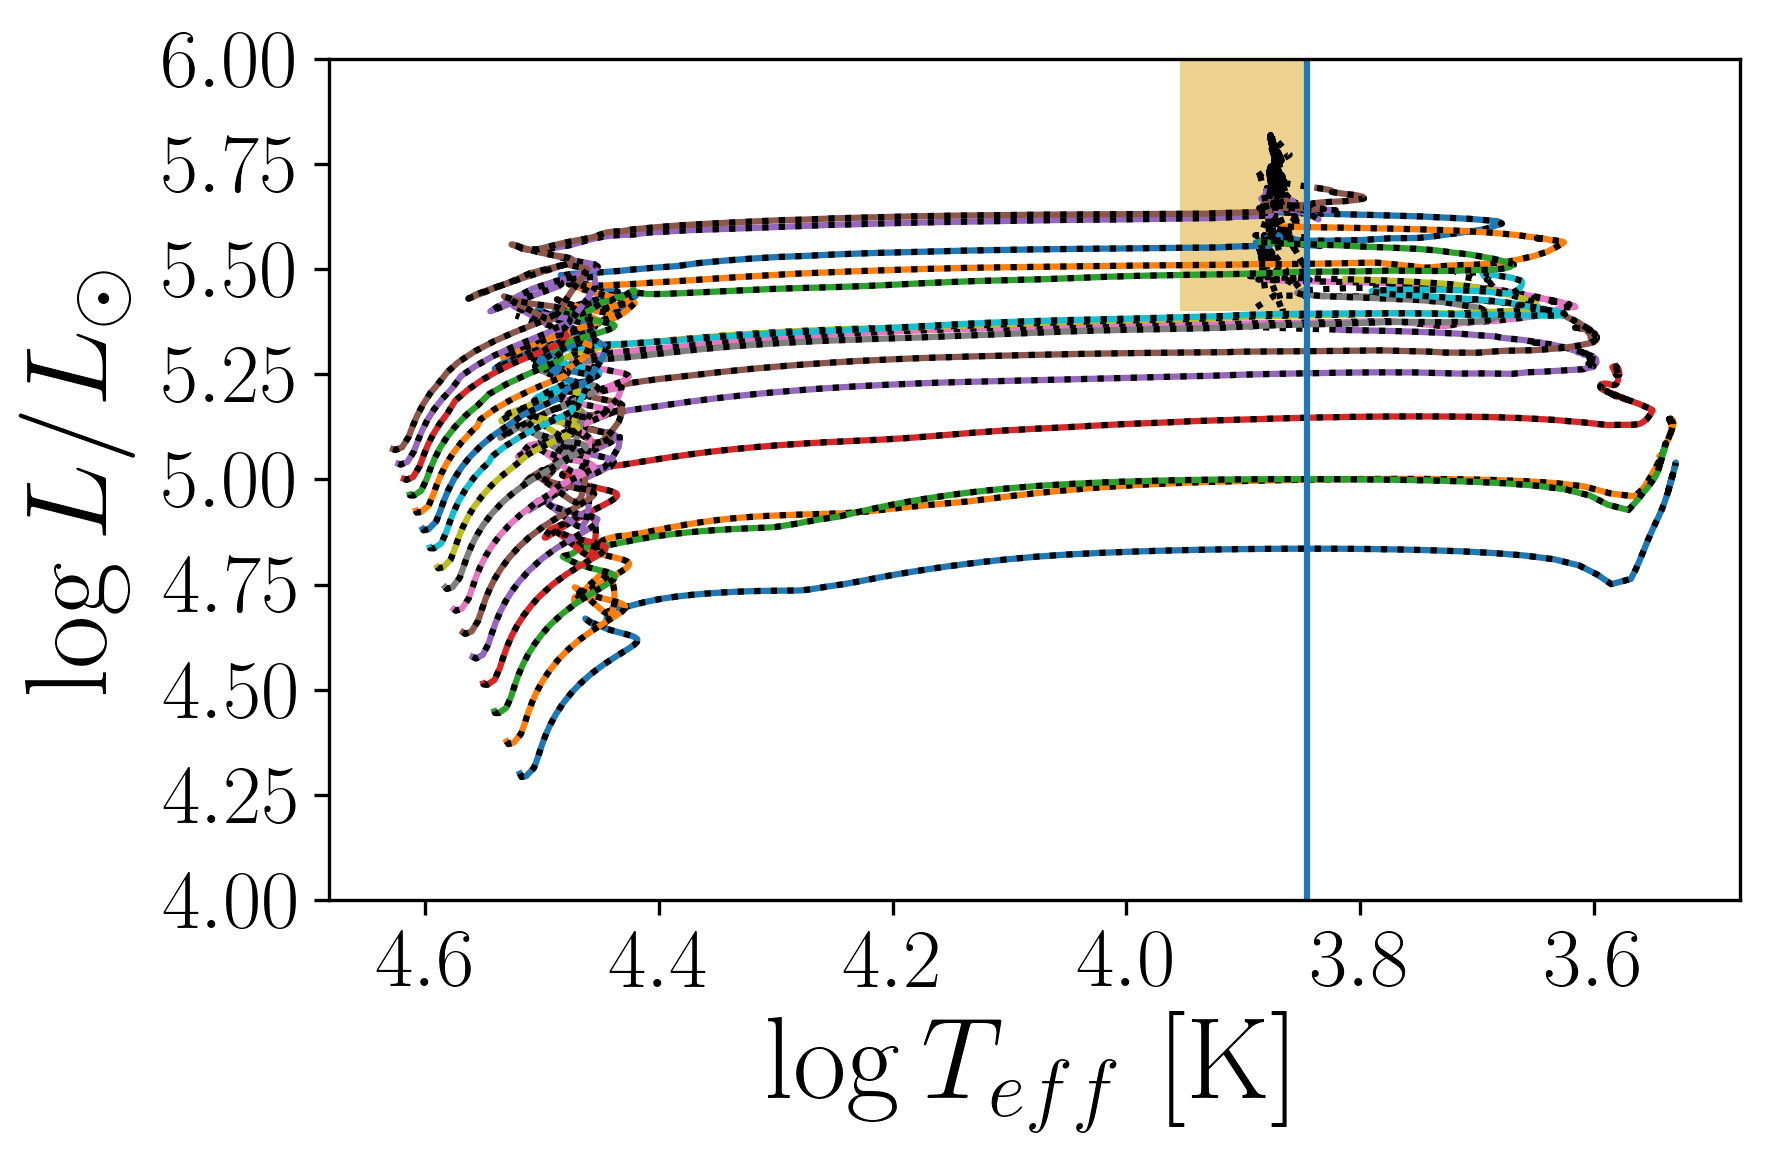

In [3]:
fig = plt.figure(dpi=300)

#Plot MESA tracks
dfs = []
for m in np.arange(15,31,dtype=int): 
    try:
        model = pd.read_csv(f'out_post/mesa_initial_mass_{m}__/mesa_profile_attributes.csv')
        model.sort_values(by='model_number',inplace=True)
        min_num = model['model_number'].loc[np.argmin(model['Teff'])]
        pre = model[model['model_number'] < min_num]
        post = model[(model['model_number'] >= min_num)]
        if post['Teff'].max() >= 7000:
            yv_num = post['model_number'][np.argmin(np.abs(post['Teff'] - 7000))]
        else:
            yv_num = model['model_number'].max()+1
        post = post[post['model_number'] < yv_num]
        plt.plot(np.log10(model['Teff'][model['model_number'] < yv_num]),np.log10(model['photosphere_L'][model['model_number'] < yv_num]))
        plt.plot(np.log10(model['Teff']),np.log10(model['photosphere_L']),c='k',ls=':')
    except:
        pass

plt.xlabel('$\log{T_{eff}}$ [K]')
plt.ylabel('$\log{L/L_\odot}$')

ax= plt.gca()
ax.invert_xaxis()
ax.xaxis.label.set_size(28)
ax.yaxis.label.set_size(28)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.ylim(4,6)
yl = ax.get_ylim()
yv = plt.axvspan(xmin=np.log10(7000),xmax=np.log10(9000),ymin=(5.4-yl[0])/(yl[1]-yl[0]),fc='goldenrod',alpha=0.5)
plt.axvline(np.log10(7000))

plt.tight_layout()
plt.savefig('example_hr.pdf')

/Users/carina/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


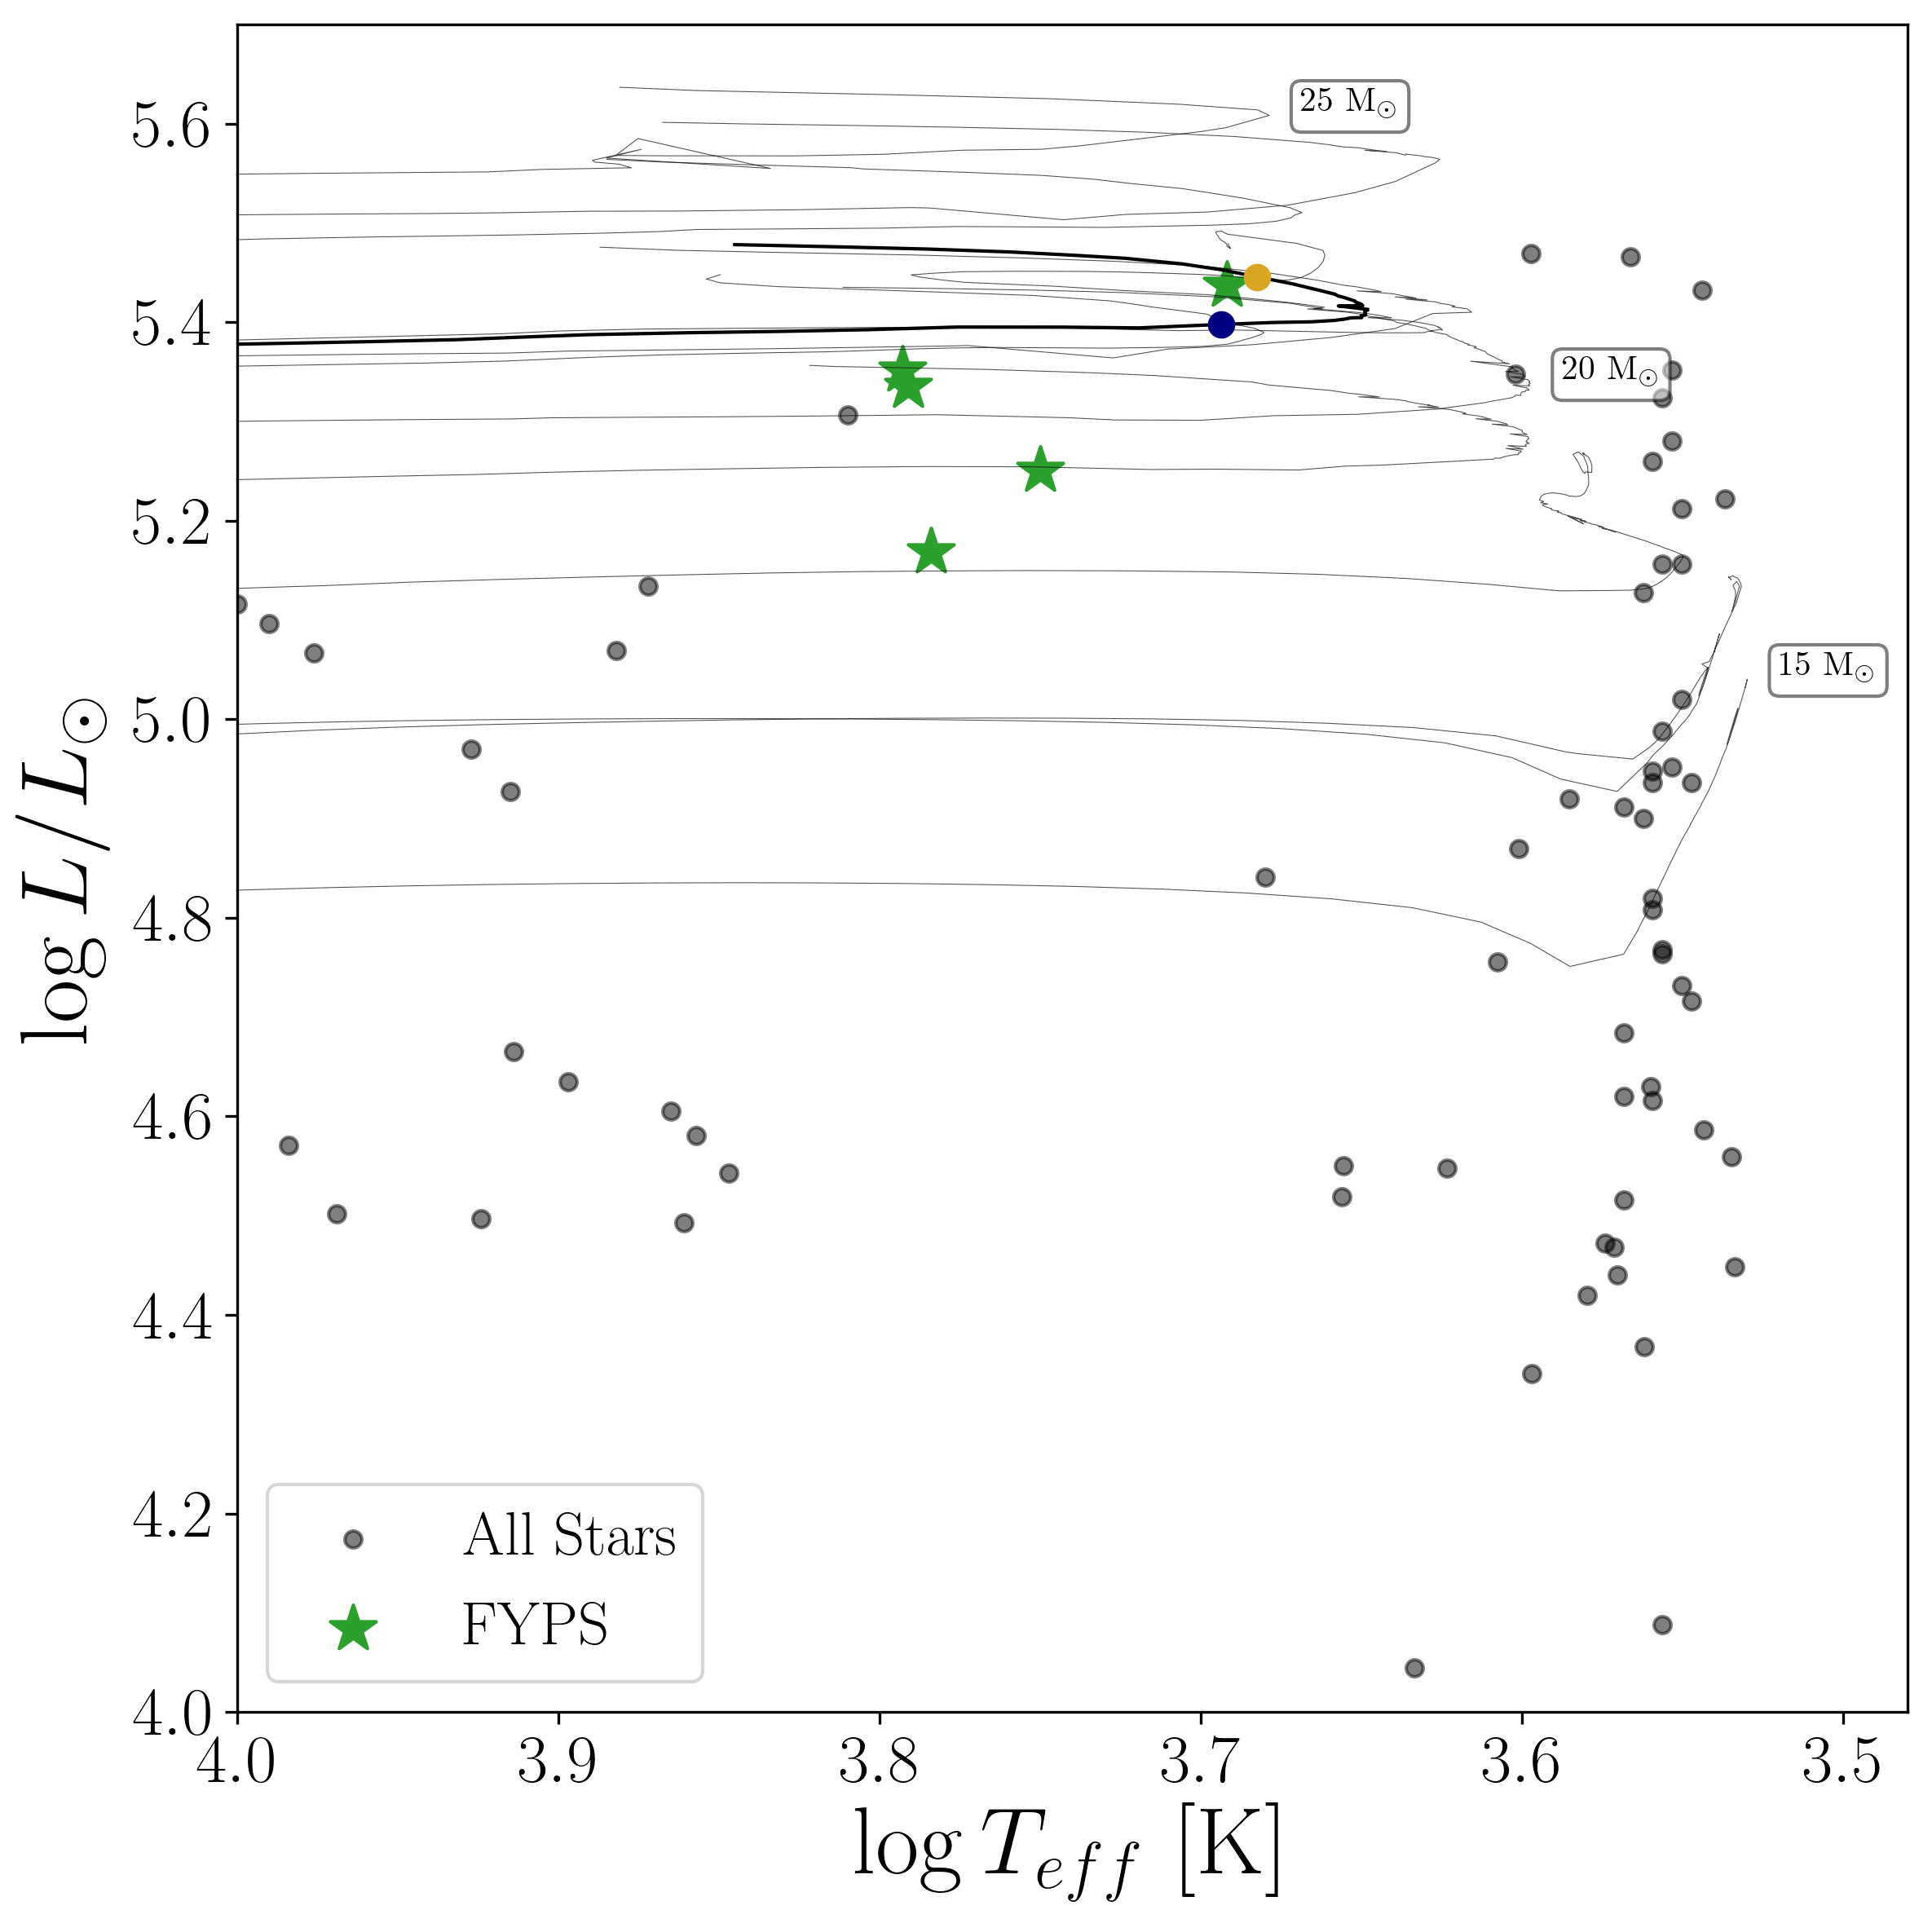

In [4]:
fig, ax = plt.subplots(dpi=300,figsize=(8,8))

#Plot MESA tracks
pre_dfs = []
post_dfs = []
for m in [15,16,17,18,19,20,21,22,23,24,25,26,27,]: 
    try:
        model = pd.read_csv(f'out_post/mesa_initial_mass_{m}__/mesa_profile_attributes.csv')
        model.sort_values(by='model_number',inplace=True)
        min_num = model['model_number'].loc[np.argmin(model['Teff'])]
        pre = model[model['model_number'] < min_num]
        pre_dfs.append(pre)
        post = model[(model['model_number'] >= min_num)]
        if post['Teff'].max() >= 7000:
            yv_num = post['model_number'][np.argmin(np.abs(post['Teff'] - 7000))]
        else:
            yv_num = model['model_number'].max()+1
        post = post[post['model_number'] < yv_num]
        post_dfs.append(post)
        ax.plot(np.log10(model['Teff'][model['model_number'] < yv_num]),np.log10(model['photosphere_L'][model['model_number'] < yv_num]),lw=0.25,alpha=0.7,c='k')
    except:
        pass
    if m % 5 == 0:
        if m == 30:
            offset = 0#.1
        else:
            offset = 0
        plt.text(np.log10(model['Teff']).min()-0.01,np.log10(model['photosphere_L'])[np.argmin(model['Teff'])]+offset,
                     str(m)+r' M$_\odot$',bbox=dict(facecolor='white',boxstyle='round',alpha=0.5))

all_pre = pd.concat(pre_dfs)
closest_match_preRSG = all_pre.iloc[np.argmin(np.sqrt((np.log10(all_pre['Teff'].values) - this_T)**2.0 + (np.log10(all_pre['photosphere_L'].values) - this_L)**2.0))]
pre_mass = int(closest_match_preRSG['initial_mass'])
best_model = pd.read_csv(f'out_post/mesa_initial_mass_{pre_mass}__/mesa_profile_attributes.csv').sort_values('model_number')
min_num = best_model['model_number'].loc[np.argmin(best_model['Teff'])]
best_pre = best_model[best_model['model_number'] < min_num]
best_post = best_model[(best_model['model_number'] >= min_num)&(best_model['Teff'] < 7000)]
ax.plot(np.log10(best_pre['Teff']),np.log10(best_pre['photosphere_L']),lw=1,c='k',zorder=2)
ax.plot(np.log10(best_post['Teff']),np.log10(best_post['photosphere_L']),lw=1,c='k',zorder=2)
close_pre = best_pre.iloc[np.argmin(np.sqrt((np.log10(best_pre['Teff'].values) - this_T)**2.0 + (np.log10(best_pre['photosphere_L'].values) - this_L)**2.0))]
close_post = best_post.iloc[np.argmin(np.sqrt((np.log10(best_post['Teff'].values) - this_T)**2.0 + (np.log10(best_post['photosphere_L'].values) - this_L)**2.0))]
plt.scatter(np.log10(close_pre['Teff']),np.log10(close_pre['photosphere_L']),c='navy',s=50, zorder=3)
plt.scatter(np.log10(close_post['Teff']),np.log10(close_post['photosphere_L']),c='goldenrod',s=50, zorder=3)

plt.xlabel('$\log{T_{eff}}$ [K]')
plt.ylabel('$\log{L/L_\odot}$')

ax.scatter(cool_sgs['teff'],cool_sgs['lum'],s=100,marker='.',c='k',alpha=0.5,label='All Stars',zorder=1)
ax.scatter(fyps['teff'],fyps['lum'],marker='*',s=200,c='C2',label='FYPS',zorder=1)
ax.legend(fontsize=18,loc='lower left')

ax.xaxis.label.set_size(28)
ax.yaxis.label.set_size(28)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
    
xl = ax.get_xlim()
ax.set_ylim(4,5.7)
#ax.set_xlim(4.8,xl[0])
ax.set_xlim(4.0,3.48)

plt.tight_layout()
plt.savefig('../../../plots/tracks_hr.pdf')

In [5]:
close_index = close_pre['profile']
print(close_index)
post_index = close_post['profile']
print(post_index)

130
154


In [6]:
close_pre[['initial_mass','star_mass','star_age']],np.log10(close_pre['Teff']),np.log10(close_pre['photosphere_L']),close_post[['initial_mass','star_mass','star_age']],np.log10(close_post['Teff']),np.log10(close_post['photosphere_L'])

(initial_mass             23
 star_mass           21.5984
 star_age        8.98355e+06
 Name: 129, dtype: object,
 3.6937747108783574,
 5.39778815117837,
 initial_mass             23
 star_mass           16.6378
 star_age        9.30332e+06
 Name: 153, dtype: object,
 3.6825924590294887,
 5.445802298697142)

In [7]:
close_post

model_number                               2460
num_zones                                  1606
initial_mass                                 23
initial_z                                 0.006
star_age                            9.30332e+06
time_step                                2906.3
Teff                                    4814.96
photosphere_L                            279127
photosphere_r                           760.283
center_eta                             -4.15144
center_h1                                     0
center_he3                                    0
center_he4                             0.360836
center_c12                             0.492149
center_n14                          2.41841e-09
center_o16                             0.139761
center_ne20                          0.00602658
star_mass                               16.6378
star_mdot                           -1.6121e-05
star_mass_h1                            2.83045
star_mass_he3                       2.99

In [8]:
from megyr.profile import read_profile_file
best_fit_dir = f'out_post/mesa_initial_mass_{pre_mass}__/'
best_fit_profs = glob(best_fit_dir+'LOGS/profile*.data')
best_model = pd.read_csv(best_fit_dir+'mesa_profile_attributes.csv').sort_values('model_number')
X_m = []
Y_m = []
mass = []
logage = []
for i,row in best_model.iterrows():
    j = i+1
    prof = read_profile_file(best_fit_dir+f"/LOGS/profile{row['profile']}.data")
    mass.append(prof.attributes['star_mass'].values[0])
    logage.append(np.log10(prof.attributes['star_age'].values[0]))
    X_flag = True
    Y_flag = False
    Z_flag = False
    for i,row in prof.data.iterrows():
        if X_flag:
            if row['y_mass_fraction_He'] >= row['x_mass_fraction_H']:
                X_flag = False
                Y_flag = True
                X_m.append(row['mass'])
        elif Y_flag:
            if row['z_mass_fraction_metals'] >= row['y_mass_fraction_He']:
                Y_flag = False
                Z_flag = True
                Y_m.append(row['mass'])
        elif Z_flag:
            break
        else:
            print('No flags set?', X_flag, Y_flag, Z_flag)
    #if the whole thing is hydrogen dominated, X_flag never got turned off
    if X_flag:
        X_m.append(0)
        Y_m.append(0)
    #if only has a helium core, no strong metals build up:
    elif Y_flag:
        Y_m.append(0)

/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


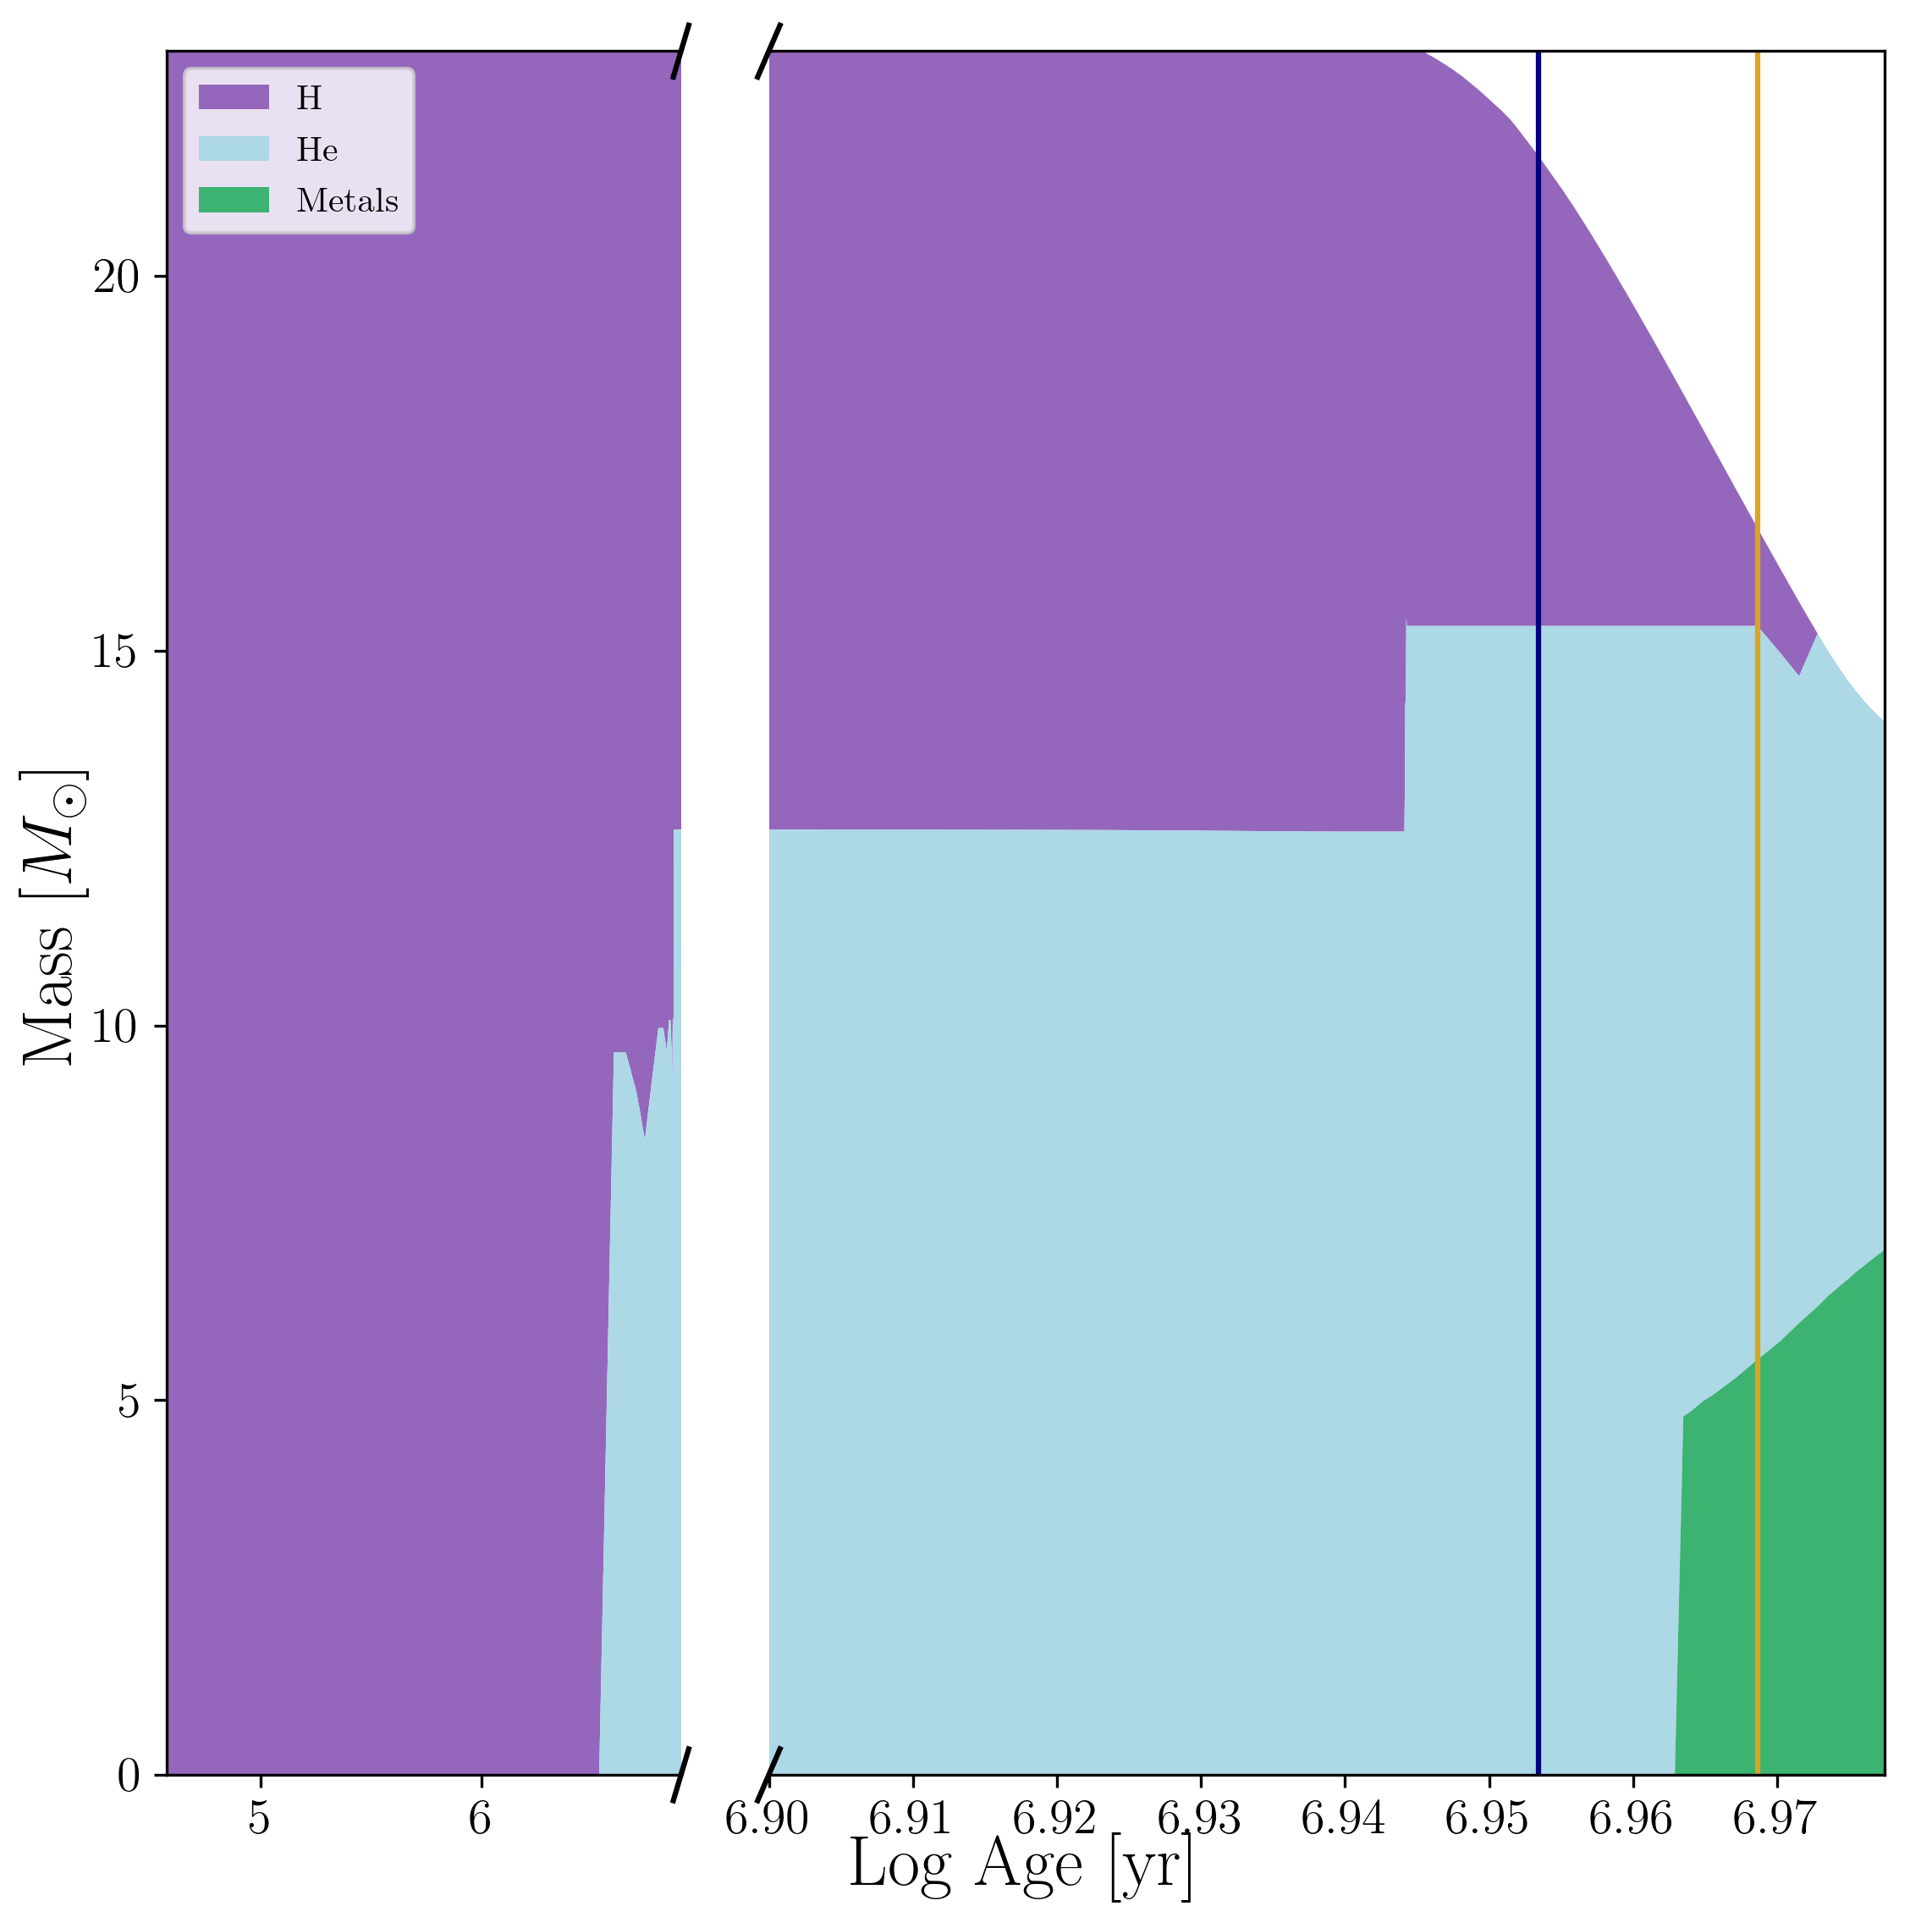

In [9]:
import matplotlib.gridspec as gridspec

f = plt.figure(constrained_layout=True, dpi=300, figsize=(8,8))
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=f)

ax = f.add_subplot(spec[0])
ax2 = f.add_subplot(spec[1:])

# plot the same data on both axes
ax.fill_between(logage,X_m,mass,fc='C4',label='H')
ax.fill_between(logage,X_m,Y_m,fc='lightblue',label='He')
ax.fill_between(logage,0,Y_m,fc='mediumseagreen',label='Metals')

# plot the same data on both axes
ax2.fill_between(logage,X_m,mass,fc='C4')
ax2.fill_between(logage,X_m,Y_m,fc='lightblue')
ax2.fill_between(logage,0,Y_m,fc='mediumseagreen')
ax2.axvline(x=np.log10(close_pre['star_age']),c='navy')
ax2.axvline(x=np.log10(close_post['star_age']),c='goldenrod')

# zoom-in / limit the view to different portions of the data
ax.set_xlim(np.min(logage), 6.9)  # outliers only
ax2.set_xlim(6.9, np.max(logage))  # most of the data

ax.set_ylim(0,pre_mass)
ax2.set_ylim(0,pre_mass)
#ax3.set_ylim(0,pre_mass)

# hide the spines between ax and ax2
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
#ax2.spines['right'].set_visible(False)
#ax3.spines['left'].set_visible(False)
ax2.tick_params(axis='y',length=0)
ax2.set_yticks([])
#ax.tick_params(labeltop=False)  # don't put tick labels at the top
#ax2.xaxis.tick_bottom()


d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
#ax2.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # top-right diagonal
ax.plot((1 - d, 1 + d), (- d, + d), **kwargs)  # bottom-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
#ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
#
ax2.plot((-2*d/3, +2*d/3), (-d, +d), **kwargs)        # bottom-left diagonal
ax2.plot((-2*d/3, +2*d/3), (1-d, 1+d), **kwargs)  # top-left diagonal
ax.legend(loc='upper left')
#ax2.set_xticks([6.75,6.8,6.85])

"""kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False)
#ax2.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # top-right diagonal
ax2.plot((1 - d, 1 + d), (- d, + d), **kwargs)  # bottom-right diagonal

kwargs.update(transform=ax3.transAxes)  # switch to the bottom axes
#ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
#
ax3.plot((-d, +d), (-d, +d), **kwargs)        # bottom-left diagonal
ax3.plot((-d, +d), (1-d, 1+d), **kwargs)  # top-left diagonal"""
#Axis labels
labax = f.add_subplot(111)
labax.spines['top'].set_color('none')
labax.spines['bottom'].set_color('none')
labax.spines['left'].set_color('none')
labax.spines['right'].set_color('none')
labax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off', length=0)
labax.set_xlabel(r'Log Age [yr]',fontsize=20,family='serif')
labax.set_ylabel(r'Mass [$M_\odot$]',fontsize=20,family='serif')
labax.set_zorder(-1)

for a in (ax,ax2):
    for tick in a.xaxis.get_major_ticks():
        tick.label.set_fontsize(14)
    for tick in a.yaxis.get_major_ticks():
        tick.label.set_fontsize(14)

f.subplots_adjust(hspace=0.25)
f.tight_layout()
plt.savefig('../../../plots/kippenhahn.pdf')

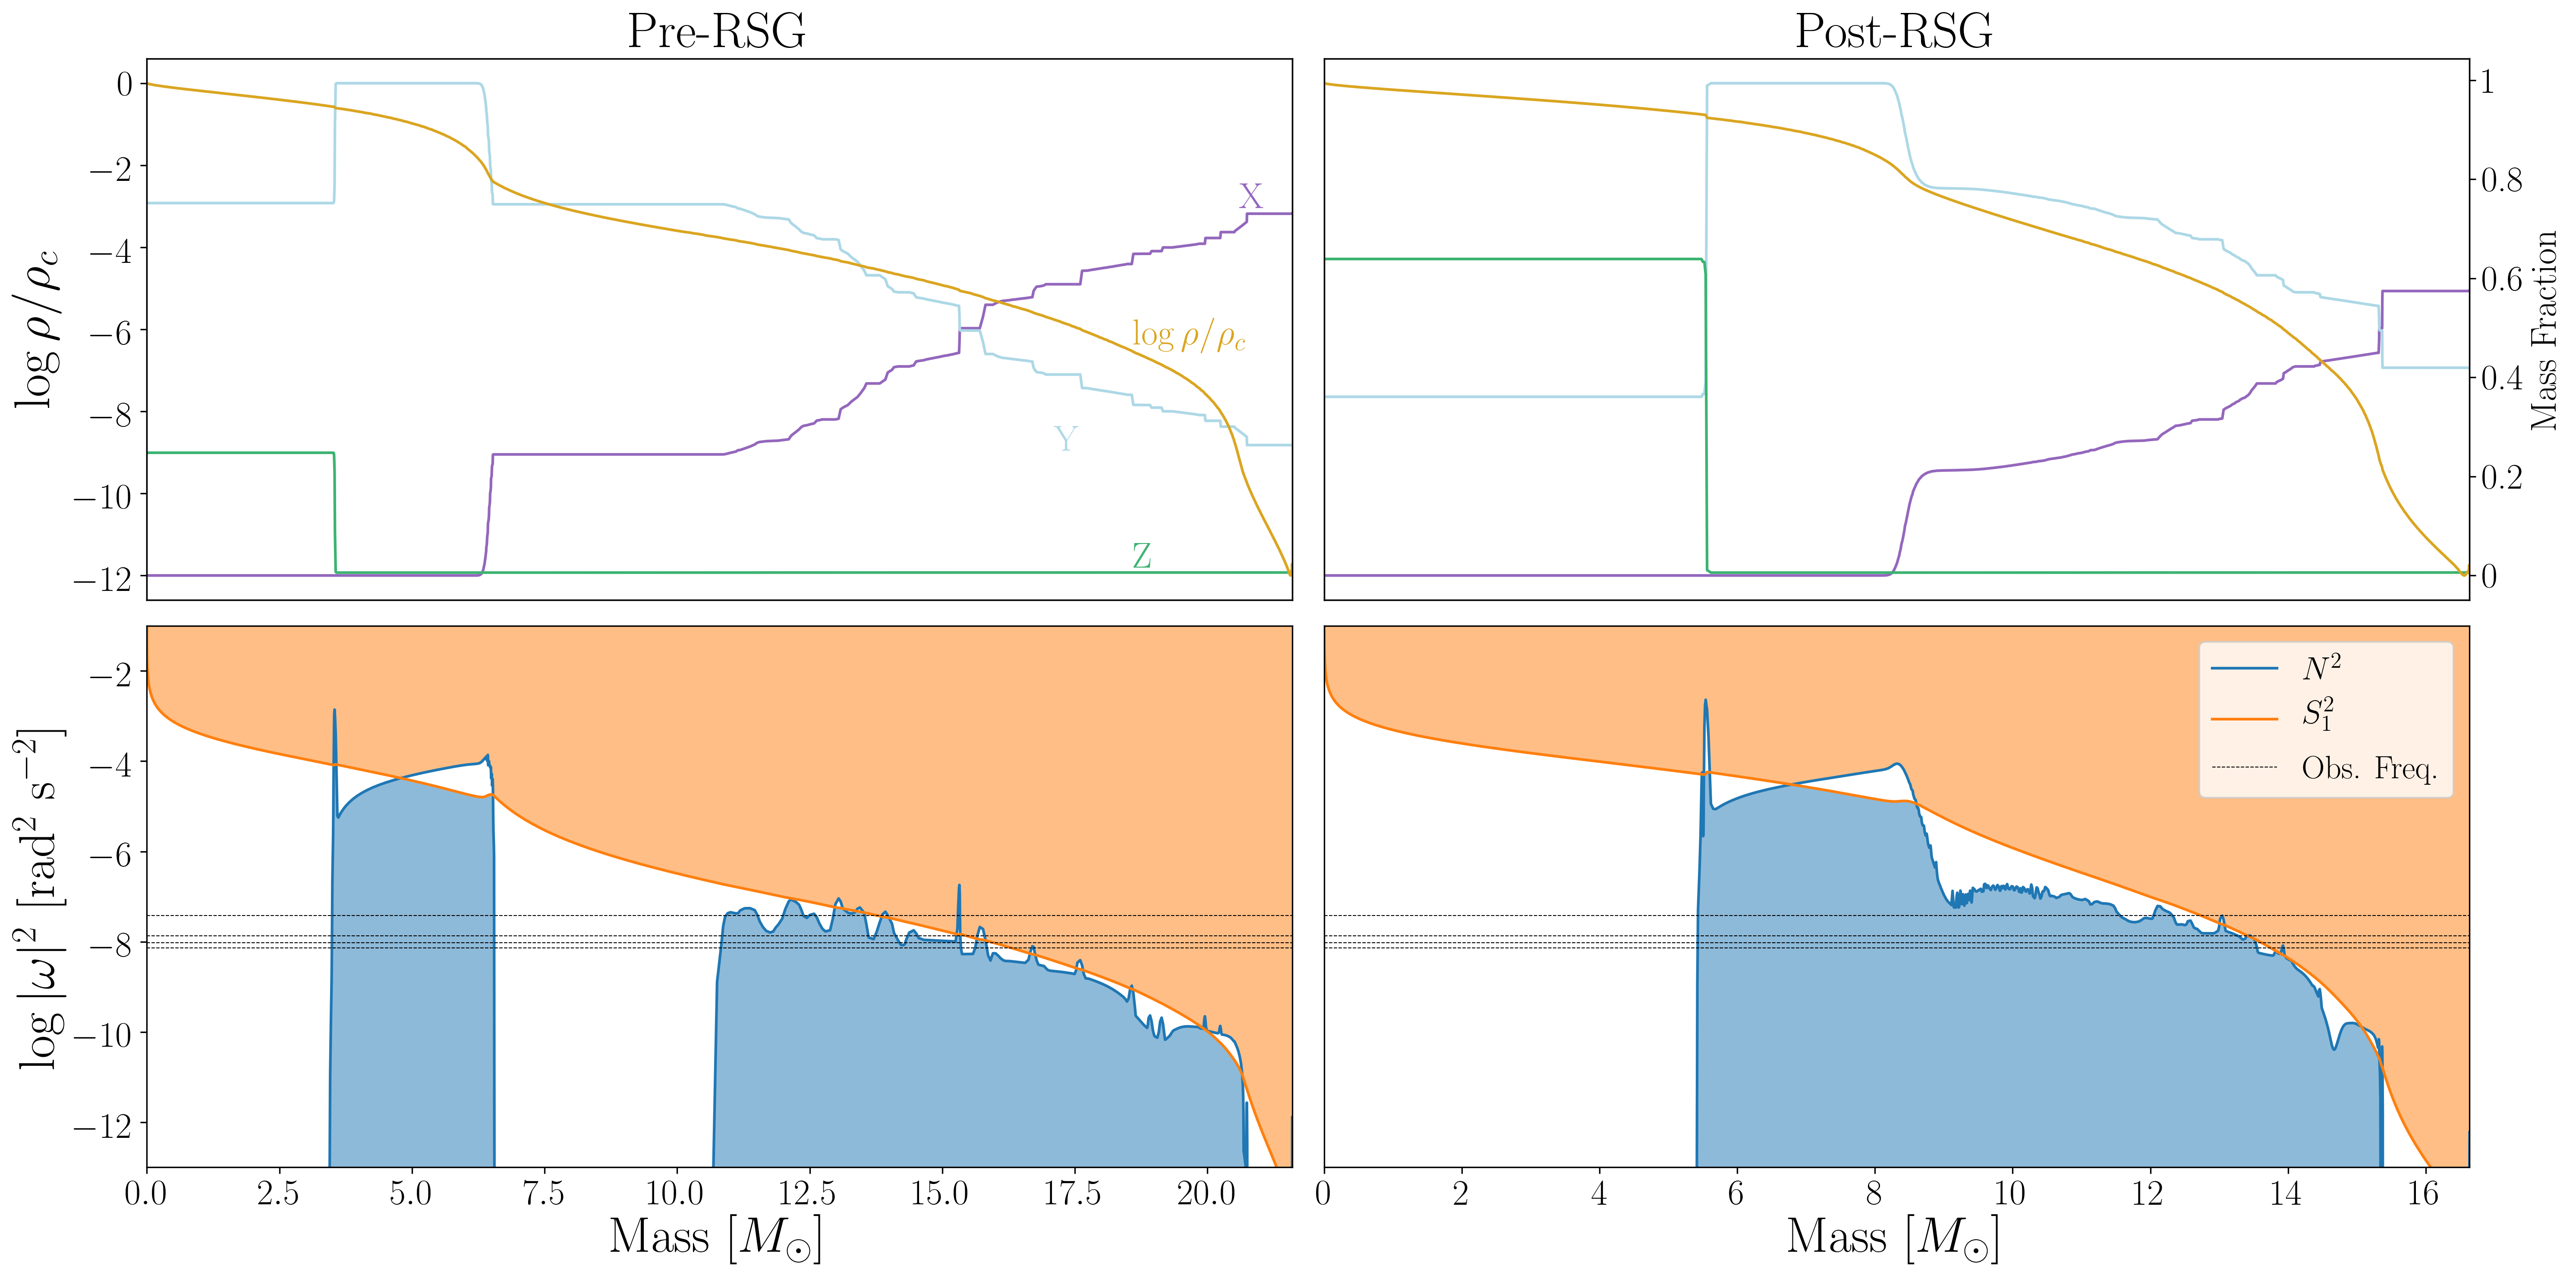

In [10]:
import astropy.units as u

these_fs = np.array([1.59347960, 2.67052158, 1.33523329, 1.17424693])
these_fs = 2*np.pi*these_fs * (u.rad/u.day).to(u.rad/u.second)

prof = read_profile_file(f'out_post/mesa_initial_mass_{pre_mass}__/LOGS/profile{close_pre["profile"]}.data')
profile = prof.data
log_N2 = np.log10(np.clip(profile['brunt_N2'].values, 1e-15, None))
log_S2 = np.log10(np.clip(profile['lamb_S2'].values, 1e-15, None))

fig, axes = plt.subplots(2,2, dpi=300,figsize=(20,10))

axes[0,0].plot(profile['mass'],profile['logRho']-profile['logRho'].max(),c='goldenrod')
axes[0,0].set_ylabel(r'$\log \rho/\rho_c$')
axes[0,0].text(profile['mass'].max()-3,-6.5,r'$\log\rho/\rho_c$',fontsize=20,c='goldenrod')
axes[0,0].set_title('Pre-RSG',fontsize=28)


twax = axes[0,0].twinx()
twax.plot(profile['mass'],profile['x_mass_fraction_H'],c='C4',label='X')
twax.plot(profile['mass'],profile['y_mass_fraction_He'],c='lightblue',label='Y')
twax.plot(profile['mass'],profile['z_mass_fraction_metals'],c='mediumseagreen',label='Z')
twax.text(profile['mass'].max()-1,profile['x_mass_fraction_H'].values[0]+0.01,'X',fontsize=20,c='C4')
twax.text(profile['mass'].max()-4.5,profile['y_mass_fraction_He'].values[0]-0.01,'Y',fontsize=20,c='lightblue')
twax.text(profile['mass'].max()-3,profile['z_mass_fraction_metals'].values[0]+0.01,'Z',fontsize=20,c='mediumseagreen')

twax.set_yticks([])
for tick in twax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
twax.set_zorder(ax2.get_zorder()-1) # put ax in front of ax2 
axes[0,0].patch.set_visible(False) # hide the 'canvas' 

axes[1,0].plot(profile['mass'],log_N2,label='$N^2$')
axes[1,0].plot(profile['mass'],log_S2,label='$S_1^2$')
max_g = []
min_p = []
for n2,s2 in zip(log_N2,log_S2):
    if n2 <= s2:
        max_g.append(n2)
        min_p.append(s2)
    else:
        max_g.append(s2)
        min_p.append(n2)
axes[1,0].fill_between(profile['mass'], max_g, axes[1,0].get_ylim()[0], facecolor='C0', alpha=0.5, interpolate=True)
axes[1,0].fill_between(profile['mass'], min_p, axes[1,0].get_ylim()[1], facecolor='C1', alpha=0.5, interpolate=True)
axes[1,0].axhline(y=np.log10(these_fs[0]**2.0),c='k',lw=0.5,ls='--',label='Obs. Freq.')
for f in these_fs[1:]:
    axes[1,0].axhline(y=np.log10(f**2.0),c='k',ls='--',lw=0.5)
axes[1,0].set_ylim(-13,-1)
axes[1,0].set_xlim(0,close_pre['star_mass'])
axes[0,0].set_xlim(0,close_pre['star_mass'])
axes[1,0].set_xlabel(r'Mass [$M_\odot$]')
axes[1,0].set_ylabel(r'$\log |\omega|^2$ [rad$^{2}$ s$^{-2}$]')


prof = read_profile_file(f'out_post/mesa_initial_mass_{pre_mass}__/LOGS/profile{close_post["profile"]}.data')
profile = prof.data
log_N2 = np.log10(np.clip(profile['brunt_N2'].values, 1e-15, None))
log_S2 = np.log10(np.clip(profile['lamb_S2'].values, 1e-15, None))

axes[0,1].plot(profile['mass'],profile['logRho']-profile['logRho'].max(),c='goldenrod')
axes[0,1].set_yticks([])
#axes[0,1].text(profile['mass'].max()-3,-6,r'$\log\rho/\rho_c$',fontsize=20,c='goldenrod')
axes[0,1].set_title('Post-RSG',fontsize=28)


twax2 = axes[0,1].twinx()
twax2.plot(profile['mass'],profile['x_mass_fraction_H'],c='C4',label='X')
twax2.plot(profile['mass'],profile['y_mass_fraction_He'],c='lightblue',label='Y')
twax2.plot(profile['mass'],profile['z_mass_fraction_metals'],c='mediumseagreen',label='Z')
#twax2.text(profile['mass'].max()-1,profile['x_mass_fraction_H'].values[0]+0.01,'X',fontsize=20,c='C4')
#twax2.text(profile['mass'].max()-4,profile['y_mass_fraction_He'].values[0]+0.01,'Y',fontsize=20,c='lightblue')
#twax2.text(profile['mass'].max()-3,profile['z_mass_fraction_metals'].values[0]+0.01,'Z',fontsize=20,c='mediumseagreen')



twax2.set_ylabel('Mass Fraction')
twax2.yaxis.label.set_size(20)
twax2.set_yticks([0,0.2,0.4,0.6,0.8,1])
twax2.set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontdict={'fontsize':20})
twax2.set_zorder(ax2.get_zorder()-1) # put ax in front of ax2 
axes[0,1].patch.set_visible(False) # hide the 'canvas' 

axes[1,1].plot(profile['mass'],log_N2,label='$N^2$')
axes[1,1].plot(profile['mass'],log_S2,label='$S_1^2$')
max_g = []
min_p = []
for n2,s2 in zip(log_N2,log_S2):
    if n2 <= s2:
        max_g.append(n2)
        min_p.append(s2)
    else:
        max_g.append(s2)
        min_p.append(n2)
axes[1,1].fill_between(profile['mass'], max_g, axes[1,1].get_ylim()[0], facecolor='C0', alpha=0.5, interpolate=True)
axes[1,1].fill_between(profile['mass'], min_p, axes[1,1].get_ylim()[1], facecolor='C1', alpha=0.5, interpolate=True)
axes[1,1].axhline(y=np.log10(these_fs[0]**2.0),c='k',lw=0.5,ls='--',label='Obs. Freq.')
for f in these_fs[1:]:
    axes[1,1].axhline(y=np.log10(f**2.0),c='k',ls='--',lw=0.5)
axes[1,1].set_ylim(-13,-1)
axes[1,1].set_xlim(0,close_post['star_mass'])
axes[0,1].set_xlim(0,close_post['star_mass'])
axes[1,1].set_xlabel(r'Mass [$M_\odot$]')
axes[1,1].set_yticks([])
axes[1,1].legend(loc='upper right',fontsize=18)


axes[0,0].set_xticks([])
axes[0,1].set_xticks([])

for ax in axes.flatten():
    ax.xaxis.label.set_size(28)
    ax.yaxis.label.set_size(28)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)

    
plt.tight_layout()


plt.savefig('../../../plots/propagation_diagram.pdf',bbox_inches='tight')

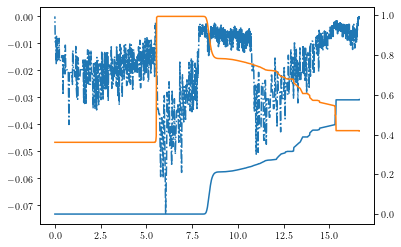

In [11]:
plt.plot(profile['mass'][:-1],np.diff(profile['mass']),'-.')
ax = plt.twinx()
ax.plot(profile['mass'],profile['x_mass_fraction_H'])
ax.plot(profile['mass'],profile['y_mass_fraction_He'])
#plt.ylim(12,15)
#plt.xlim(650,750)

In [12]:
[1,0][0:2]

[1, 0]